## Prerequisites installation / Setup

### connect to GPU runtime before starting
otherwise error will occur during model training

### install PyTorch

ref:
https://pytorch.org/tutorials/beginner/colab.html

In [1]:
! pip3 install torch torchaudio torchvision torchtext torchdata

### import pre requisites

In [13]:
import numpy as np
import os

# from tqdm import tqdm
from tqdm.notebook import tqdm

### clone repository

In [14]:
! ls -la

total 16
drwxr-xr-x 1 root root 4096 Oct  5 19:33 .
drwxr-xr-x 1 root root 4096 Oct  9 10:43 ..
drwxr-xr-x 4 root root 4096 Oct  5 19:32 .config
drwxr-xr-x 1 root root 4096 Oct  5 19:33 sample_data


In [15]:
! pwd

/content


In [16]:
! git clone -b branch1 https://github.com/itsMohitShah/MyoArmbandDataset.git

Cloning into 'MyoArmbandDataset'...
remote: Enumerating objects: 2478, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 2478 (delta 2), reused 2 (delta 0), pack-reused 2469
Receiving objects: 100% (2478/2478), 28.91 MiB | 7.49 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [17]:
! ls -la MyoArmbandDataset/

total 228
drwxr-xr-x  9 root root   4096 Oct  9 10:48 .
drwxr-xr-x  1 root root   4096 Oct  9 10:47 ..
drwxr-xr-x  2 root root   4096 Oct  9 10:48 CWT
drwxr-xr-x 20 root root   4096 Oct  9 10:48 EvaluationDataset
-rw-r--r--  1 root root 147738 Oct  9 10:48 file_reader.ipynb
-rw-r--r--  1 root root   3814 Oct  9 10:48 file_reader_wip.py
drwxr-xr-x  8 root root   4096 Oct  9 10:48 .git
drwxr-xr-x  2 root root   4096 Oct  9 10:48 .idea
-rw-r--r--  1 root root  35147 Oct  9 10:48 LICENSE
drwxr-xr-x 24 root root   4096 Oct  9 10:48 PreTrainingDataset
drwxr-xr-x  5 root root   4096 Oct  9 10:48 PyTorchImplementation
-rw-r--r--  1 root root   3481 Oct  9 10:48 README.md
drwxr-xr-x  2 root root   4096 Oct  9 10:48 Spectrogram


## Pre Processing & Pre Training

### generate plots
Mohit file reader implementation

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
# from tqdm import tqdm
from tqdm.notebook import tqdm
import time
from datetime import timedelta

In [8]:
number_of_vector_per_example = 52
number_of_canals = 8
number_of_classes = 7
size_non_overlap = 5

In [9]:
def format_data_to_train(vector_to_format):
    dataset_example_formatted = []
    example = []
    emg_vector = []
    for value in vector_to_format:
        emg_vector.append(value)
        if (len(emg_vector) >= 8):
            if (len(example) == 0):
                example = emg_vector
            else:
                example = np.row_stack((example, emg_vector))
            emg_vector = []
            if (len(example) >= number_of_vector_per_example): #number of vector per example =52. Len (example) =8x1, 8x2....8*7 >>>7x8(appended to dataset example formatted)>>>>8x7
                example = example.transpose()
                dataset_example_formatted.append(example)
                example = example.transpose()
                example = example[size_non_overlap:]
    return dataset_example_formatted

In [10]:
def plot_generator(list_path_allclasses):
    total_count=0
    for path in tqdm(list_path_allclasses):
        print("Generating plot...")
        data_read_from_file = np.fromfile(path, dtype=np.int16)
        data_read_from_file = np.array(data_read_from_file, dtype=np.float32)
        # print(f"Gathering dataset of {path}")
        dataset_example = format_data_to_train(data_read_from_file)
        print(f"Gathered dataset of {path}")
        count = 0
        for samples in range(len(dataset_example)):
            training_plot = dataset_example[samples]
            fig,ax = plt.subplots(nrows=8,ncols=1, figsize=(10,10),sharex=True)
            for channel in range(np.shape(training_plot)[0]):
                ax[channel].plot(training_plot[channel])
                # ax[channel].set_title(f"Channel : {channel}")
            plt.tight_layout()
            name_plotfolder=path.split('.')[0]
            name_plotfolder=name_plotfolder.split('\\')[-1]
            name_plotfolder="plots_"+name_plotfolder
            path_plotfolder=os.path.join(os.path.dirname(path),name_plotfolder)
            os.makedirs(path_plotfolder,exist_ok=True)
            plot_path=os.path.join(path_plotfolder,f'class0_{count}.png')
            fig.savefig(plot_path)
            # plt.show()
            plt.close()
            count+=1
            total_count+=1

        print(f"Plots generated of {path}")
    print(f"Total Number of images generated : {total_count}")


In [11]:
def path_retriever(root):
    print("Retrieving paths...")
    list_humans = os.listdir(root)
    list_path_allclasses=[]
    for each_human in tqdm(list_humans):
        path_each_human=os.path.join(root,each_human)
        list_trainingfolders=os.listdir(path_each_human)
        for each_trainingfolder in list_trainingfolders:
            path_trainingfolder = os.path.join(path_each_human,each_trainingfolder)
            if os.path.isdir(path_trainingfolder):
                list_classes=os.listdir(path_trainingfolder)
                for each_insidetrainingfolder in list_classes:
                    path_each_class = os.path.join(path_trainingfolder,each_insidetrainingfolder)
                    if os.path.isfile(path_each_class):
                        list_path_allclasses.append(path_each_class)
                    else:
                        pass
            else:
                pass
    print("Paths retrieved")
    return list_path_allclasses


Retrieving paths...


  0%|          | 0/22 [00:00<?, ?it/s]

Paths retrieved


  0%|          | 0/616 [00:00<?, ?it/s]

Generating plot...
Gathered dataset of MyoArmbandDataset/PreTrainingDataset/Male2/training0/classe_0.dat


KeyboardInterrupt: ignored

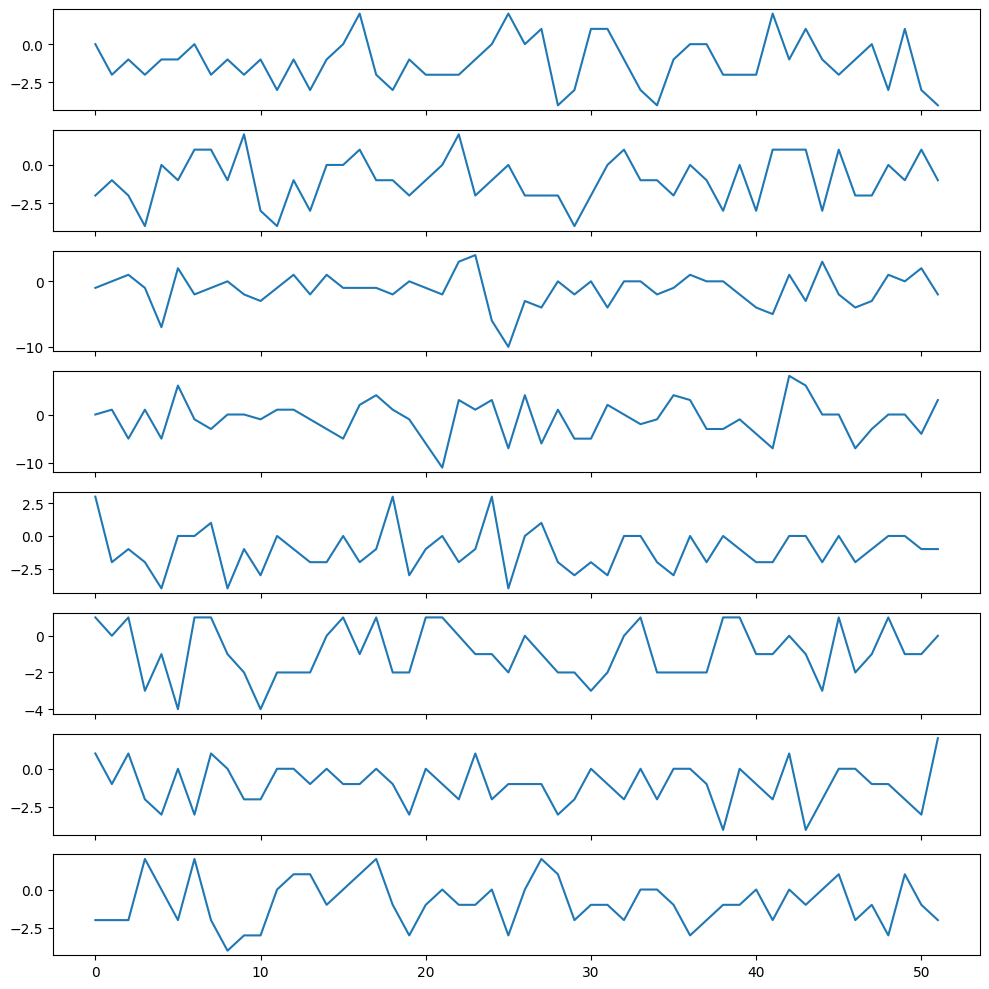

In [12]:
start = time.time()
root = os.path.join("MyoArmbandDataset", "PreTrainingDataset")
# root = r'PreTrainingDataset'
list_path_allclasses = path_retriever(root)
plot_generator(list_path_allclasses)

elapsed_time = time.time() - start

In [ ]:
print(str(timedelta(seconds=elapsed_time)))

### read and format data

repository implementation

https://github.com/itsMohitShah/MyoArmbandDataset/blob/branch1/PyTorchImplementation/RawEnhancedConvNet/load_pre_training_dataset.py

#### format data, butter high pass filter and shift electrodes

In [1]:
import numpy as np
from scipy import signal

number_of_vector_per_example = 52
number_of_canals = 8
number_of_classes = 7
size_non_overlap = 5

def format_data_to_train(vector_to_format):
    dataset_example_formatted = []
    example = []
    emg_vector = []
    for value in vector_to_format:
        emg_vector.append(value)
        if (len(emg_vector) >= 8):
            if (example == []):
                example = emg_vector
            else:
                example = np.row_stack((example, emg_vector))
            emg_vector = []
            if (len(example) >= number_of_vector_per_example):
                example = example.transpose()
                dataset_example_formatted.append(example)
                example = example.transpose()
                example = example[size_non_overlap:]
    # Apply the butterworth high pass filter at 2Hz
    dataset_high_pass_filtered = []
    for example in dataset_example_formatted:
        example_filtered = []
        for channel_example in example:
            example_filtered.append(butter_highpass_filter(channel_example, 2, 200))
        dataset_high_pass_filtered.append([example_filtered])
    return np.array(dataset_high_pass_filtered)

def butter_highpass(cutoff, fs, order=3):
    nyq = .5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=3):
    b, a = butter_highpass(cutoff=cutoff, fs=fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def shift_electrodes(examples, labels):
    index_normal_class = [1, 2, 6, 2]  # The normal activation of the electrodes.
    class_mean = []
    # For the classes that are relatively invariant to the highest canals activation, we get on average for a
    # subject the most active canals for those classes
    for classe in range(3, 7):
        X_example = []
        Y_example = []
        for k in range(len(examples)):
            X_example.extend(examples[k])
            Y_example.extend(labels[k])

        cwt_add = []
        for j in range(len(X_example)):
            if Y_example[j] == classe:
                if cwt_add == []:
                    cwt_add = np.array(X_example[j][0])
                else:
                    cwt_add += np.array(X_example[j][0])
        class_mean.append(np.argmax(np.sum(np.array(cwt_add), axis=0)))

    # We check how many we have to shift for each channels to get back to the normal activation
    new_cwt_emplacement_left = ((np.array(class_mean) - np.array(index_normal_class)) % 10)
    new_cwt_emplacement_right = ((np.array(index_normal_class) - np.array(class_mean)) % 10)

    shifts_array = []
    for valueA, valueB in zip(new_cwt_emplacement_left, new_cwt_emplacement_right):
        if valueA < valueB:
            # We want to shift toward the left (the start of the array)
            orientation = -1
            shifts_array.append(orientation*valueA)
        else:
            # We want to shift toward the right (the end of the array)
            orientation = 1
            shifts_array.append(orientation*valueB)

    # We get the mean amount of shift and round it up to get a discrete number representing how much we have to shift
    # if we consider all the canals
    # Do the shifting only if the absolute mean is greater or equal to 0.5
    final_shifting = np.mean(np.array(shifts_array))
    if abs(final_shifting) >= 0.5:
        final_shifting = int(np.round(final_shifting))
    else:
        final_shifting = 0

    # Build the dataset of the candiate with the circular shift taken into account.
    X_example = []
    Y_example = []
    for k in range(len(examples)):
        sub_ensemble_example = []
        for example in examples[k]:
            sub_ensemble_example.append(np.roll(np.array(example), final_shifting))
        X_example.append(sub_ensemble_example)
        Y_example.append(labels[k])
    return X_example, Y_example




#### read the data for pre training

In [2]:
def read_data(path):
    print("Reading Data")
    list_dataset = []
    list_labels = []

    print("Reading Male Candidate Data")
    for candidate in tqdm(range(12), desc="candidate main loop"):
        labels = []
        examples = []
        for i in tqdm(range(number_of_classes * 4), leave=True, desc='classes iteration #%d'%candidate):
            data_read_from_file = np.fromfile(path+'/Male'+str(candidate)+'/training0/classe_%d.dat' % i,
                                              dtype=np.int16)
            data_read_from_file = np.array(data_read_from_file, dtype=np.float32)
            dataset_example = format_data_to_train(data_read_from_file)
            examples.append(dataset_example)
            labels.append((i % number_of_classes) + np.zeros(dataset_example.shape[0]))
        examples, labels = shift_electrodes(examples, labels)
        list_dataset.append(examples)
        list_labels.append(labels)

    print("Reading Female Candidate Data")
    # for candidate in range(7):
    for candidate in tqdm(range(7), desc="candidate main loop"):
        labels = []
        examples = []
        # for i in range(number_of_classes * 4):
        for i in tqdm(range(number_of_classes * 4), leave=True, desc='classes iteration #%d'%candidate):
            i=0
            data_read_from_file = np.fromfile(path + '/Female' + str(candidate) + '/training0/classe_%d.dat' % i,
                                              dtype=np.int16)
            data_read_from_file = np.array(data_read_from_file, dtype=np.float32)
            dataset_example = format_data_to_train(data_read_from_file)
            examples.append(dataset_example)
            labels.append((i % number_of_classes) + np.zeros(dataset_example.shape[0]))
        examples, labels = shift_electrodes(examples, labels)
        list_dataset.append(examples)
        list_labels.append(labels)

    print("Finished Reading Data")
    return list_dataset, list_labels

## Training



scale layer

In [3]:
# from ScaleLayer import ScaleLayer

import torch
from torch import nn
from torch.nn.parameter import Parameter

class ScaleLayer(nn.Module):
    def __init__(self, parameters_dimensions=(1, 1, 1, 1), init_value=1):
        super().__init__()
        self.scale = Parameter(torch.ones(parameters_dimensions)*init_value)

    def forward(self, input):
        return input*self.scale

### Source network

In [4]:
import numpy as np

import torch
import torch.nn as nn

# from ScaleLayer import ScaleLayer


class SourceNetwork(nn.Module):
    def __init__(self, number_of_class, dropout_rate=.5):
        super(SourceNetwork, self).__init__()
        self._conv1 = nn.Conv2d(1, 32, kernel_size=(3, 5))
        self._pool1 = nn.MaxPool2d(kernel_size=(1, 3))
        self._batch_norm1 = nn.BatchNorm2d(32)
        self._prelu1 = nn.PReLU(32)
        self._dropout1 = nn.Dropout2d(dropout_rate)

        self._conv2 = nn.Conv2d(32, 64, kernel_size=(3, 5))
        self._pool2 = nn.MaxPool2d(kernel_size=(1, 3))
        self._batch_norm2 = nn.BatchNorm2d(64)
        self._prelu2 = nn.PReLU(64)
        self._dropout2 = nn.Dropout2d(dropout_rate)

        self._fc1 = nn.Linear(1024, 500)
        self._batch_norm3 = nn.BatchNorm1d(500)
        self._prelu3 = nn.PReLU(500)
        self._dropout3 = nn.Dropout(dropout_rate)

        self._output = nn.Linear(500, number_of_class)

        self.initialize_weights()

        print(self)

        print("Number Parameters: ", self.get_n_params())

    def get_n_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        number_params = sum([np.prod(p.size()) for p in model_parameters])
        return number_params

    def init_weights(self):
        for m in self.modules():
            torch.nn.init.kaiming_normal(m.weight)
            m.bias.data.zero_()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        conv1 = self._dropout1(self._prelu1(self._batch_norm1(self._conv1(x))))
        pool1 = self._pool1(conv1)
        conv2 = self._dropout2(self._prelu2(self._batch_norm2(self._conv2(pool1))))
        pool2 = self._pool2(conv2)
        flatten_tensor = pool2.view(-1, 1024)

        fc1 = self._dropout3(self._prelu3(self._batch_norm3(self._fc1(flatten_tensor))))
        output = self._output(fc1)
        return output


### target network

In [5]:

class TargetNetwork(nn.Module):
    def __init__(self, number_of_class, weights_pre_trained_convnet, dropout=.5):
        super(TargetNetwork, self).__init__()
        self._target_conv1 = nn.Conv2d(1, 32, kernel_size=(3, 5))
        self._target_pool1 = nn.MaxPool2d(kernel_size=(1, 3))
        self._target_batch_norm1 = nn.BatchNorm2d(32)
        self._target_prelu1 = nn.PReLU(32)
        self._target_dropout1 = nn.Dropout2d(dropout)

        self._target_conv2 = nn.Conv2d(32, 64, kernel_size=(3, 5))
        self._target_pool2 = nn.MaxPool2d(kernel_size=(1, 3))
        self._target_batch_norm2 = nn.BatchNorm2d(64)
        self._target_prelu2 = nn.PReLU(64)
        self._target_dropout2 = nn.Dropout2d(dropout)

        self._target_fc1 = nn.Linear(1024, 500)
        self._target_batch_norm3 = nn.BatchNorm1d(500)
        self._target_prelu3 = nn.PReLU(500)
        self._target_dropout3 = nn.Dropout(dropout)

        self._target_output = nn.Linear(500, number_of_class)

        self._source_weight_merge_1 = ScaleLayer((1, 32, 1, 1))
        self._source_weight_merge_2 = ScaleLayer((1, 64, 1, 1))
        self._source_weight_merge_3 = ScaleLayer((1, 500))

        self.initialize_weights()

        # Start with the pre-trained model
        #Change to seven for the new gesture target network (number of class)
        pre_trained_model = SourceNetwork(number_of_class=7, dropout_rate=dropout)
        self._added_source_network_to_graph = nn.Sequential(*list(pre_trained_model.children()))

        print("Number Parameters: ", self.get_n_params())

        # Load the pre-trained model weights (Source Network)
        pre_trained_model.load_state_dict(weights_pre_trained_convnet)

        # Freeze the weights of the pre-trained model so they do not change during training of the target network
        # (except for the BN layers that will be trained as normal).
        for child in pre_trained_model.children():
            if isinstance(child, nn.BatchNorm2d) is False:
                for param in child.parameters():
                    param.requires_grad = False

        self._source_network = pre_trained_model._modules
        print(self._source_network.keys())

    def get_n_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        number_params = sum([np.prod(p.size()) for p in model_parameters])
        return number_params

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        conv1 = self._source_network["_dropout1"](self._source_network["_prelu1"](
            self._source_network["_batch_norm1"](self._source_network["_conv1"](x))))
        conv1_target = self._target_dropout1(self._target_prelu1(self._target_batch_norm1(self._target_conv1(x))))
        conv1_target_added = conv1_target + self._source_weight_merge_1(conv1)

        pool1 = self._source_network["_pool1"](conv1)
        pool1_target = self._target_pool1(conv1_target_added)

        conv2 = self._source_network["_dropout2"](self._source_network["_prelu2"](
            self._source_network["_batch_norm2"](self._source_network["_conv2"](pool1))))
        conv2_target = self._target_dropout2(self._target_prelu2(self._target_batch_norm2(self._target_conv2(pool1_target))))
        conv2_target_added = conv2_target + self._source_weight_merge_2(conv2)

        pool2 = self._source_network["_pool2"](conv2)
        pool2_target = self._target_pool2(conv2_target_added)

        # print(np.shape(pool2))
        flatten_tensor = pool2.view(-1, 1024)
        flatten_tensor_target = pool2_target.view(-1, 1024)

        fc1 = self._source_network["_dropout3"](self._source_network["_prelu3"](
            self._source_network["_batch_norm3"](self._source_network["_fc1"](flatten_tensor))))
        fc1_target = self._target_dropout3(
            self._target_prelu3(self._target_batch_norm3(self._target_fc1(flatten_tensor_target))))
        fc1_target_added = fc1_target + self._source_weight_merge_3(fc1)
        output = self._target_output(fc1_target_added)
        return output

## Evaluate Target Network (Transfer Learning)

### Train on pre training data -> evaluate on evaluation data

https://github.com/itsMohitShah/MyoArmbandDataset/blob/branch1/PyTorchImplementation/RawEnhancedConvNet/evaluate_target_network_on_evaluation.py

#### imports

In [6]:
import numpy as np
import copy
import time

import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# import target_network_raw_emg_enhanced
# import load_pre_training_dataset
# import load_evaluation_dataset
# // code directly imported in cells below, made changes - direct call to function

#### helper

In [7]:
def scramble(examples, labels, second_labels=[]):
    random_vec = np.arange(len(labels))
    np.random.shuffle(random_vec)
    new_labels = []
    new_examples = []
    if len(second_labels) == len(labels):
        new_second_labels = []
        for i in random_vec:
            new_labels.append(labels[i])
            new_examples.append(examples[i])
            new_second_labels.append(second_labels[i])
        return new_examples, new_labels, new_second_labels
    else:
        for i in random_vec:
            new_labels.append(labels[i])
            new_examples.append(examples[i])
        return new_examples, new_labels


#### pre training

In [8]:

def calculate_pre_training(examples, labels):
    list_train_dataloader = []
    list_validation_dataloader = []
    human_number = 0
    for j in range(19):
        examples_personne_training = []
        labels_gesture_personne_training = []
        labels_human_personne_training = []

        examples_personne_valid = []
        labels_gesture_personne_valid = []
        labels_human_personne_valid = []

        for k in range(len(examples[j])):
            if k < 21:
                examples_personne_training.extend(examples[j][k])
                labels_gesture_personne_training.extend(labels[j][k])
                labels_human_personne_training.extend(human_number * np.ones(len(labels[j][k])))
            else:
                examples_personne_valid.extend(examples[j][k])
                labels_gesture_personne_valid.extend(labels[j][k])
                labels_human_personne_valid.extend(human_number * np.ones(len(labels[j][k])))

        print(np.shape(examples_personne_training))
        examples_personne_scrambled, labels_gesture_personne_scrambled, labels_human_personne_scrambled = scramble(
            examples_personne_training, labels_gesture_personne_training, labels_human_personne_training)

        examples_personne_scrambled_valid, labels_gesture_personne_scrambled_valid, labels_human_personne_scrambled_valid = scramble(
            examples_personne_valid, labels_gesture_personne_valid, labels_human_personne_valid)

        train = TensorDataset(torch.from_numpy(np.array(examples_personne_scrambled, dtype=np.float32)),
                              torch.from_numpy(np.array(labels_gesture_personne_scrambled, dtype=np.int64)))
        validation = TensorDataset(torch.from_numpy(np.array(examples_personne_scrambled_valid, dtype=np.float32)),
                                   torch.from_numpy(np.array(labels_gesture_personne_scrambled_valid, dtype=np.int64)))

        trainLoader = torch.utils.data.DataLoader(train, batch_size=3315, shuffle=True, drop_last=True)
        validationLoader = torch.utils.data.DataLoader(validation, batch_size=1312, shuffle=True, drop_last=True)

        list_train_dataloader.append(trainLoader)
        list_validation_dataloader.append(validationLoader)

        human_number += 1
        print("Shape training : ", np.shape(examples_personne_scrambled))
        print("Shape valid : ", np.shape(examples_personne_scrambled_valid))

    # cnn = target_network_raw_emg_enhanced.SourceNetwork(number_of_class=7, dropout_rate=.35).cuda()
    cnn = SourceNetwork(number_of_class=7, dropout_rate=.35).cuda()

    criterion = nn.CrossEntropyLoss(size_average=False)
    optimizer = optim.Adam(cnn.parameters(), lr=0.002335721469090121)
    precision = 1e-8
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=.2, patience=15,
                                                     verbose=True, eps=precision)

    pre_train_model(cnn, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                    dataloaders={"train": list_train_dataloader, "val": list_validation_dataloader},
                    precision=precision)


#### pre train model

In [26]:

def pre_train_model(cnn, criterion, optimizer, scheduler, dataloaders, num_epochs=500, precision=1e-8):
    since = time.time()

    # Create a list of dictionaries that will hold the weights of the batch normalisation layers for each dataset
    #  (i.e. each participants)
    list_dictionaries_BN_weights = []
    for index_BN_weights in range(len(dataloaders['val'])):
        state_dict = cnn.state_dict()
        batch_norm_dict = {}
        for key in state_dict:
            if "batch_norm" in key:
                batch_norm_dict.update({key: state_dict[key]})
        list_dictionaries_BN_weights.append(copy.deepcopy(batch_norm_dict))

    best_loss = float('inf')

    best_weights = copy.deepcopy(cnn.state_dict())

    patience = 30
    patience_increase = 30
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                cnn.train(True)  # Set model to training mode
            else:
                cnn.train(False)  # Set model to evaluate mode

            running_loss = 0.
            running_corrects = 0
            total = 0

            # Get a random order for the training dataset
            random_vec = np.arange(len(dataloaders[phase]))
            np.random.shuffle(random_vec)

            for dataset_index in random_vec:
                # Retrieves the BN weights calculated so far for this dataset
                BN_weights = list_dictionaries_BN_weights[dataset_index]
                cnn.load_state_dict(BN_weights, strict=False)

                loss_over_datasets = 0.
                correct_over_datasets = 0.
                for i, data in enumerate(dataloaders[phase][dataset_index], 0):
                    # get the inputs
                    inputs, labels = data

                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    if phase == 'train':
                        cnn.train()
                        # forward
                        outputs = cnn(inputs)
                        _, predictions = torch.max(outputs.data, 1)
                        # backward
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        loss = loss.item()

                    else:
                        cnn.eval()
                        # forward
                        outputs = cnn(inputs)
                        _, predictions = torch.max(outputs.data, 1)
                        loss = criterion(outputs, labels)
                        loss = loss.item()
                    # Statistic for this dataset
                    loss_over_datasets += loss
                    correct_over_datasets += torch.sum(predictions == labels.data)
                    total += labels.size(0)
                # Statistic global
                running_loss += loss_over_datasets
                running_corrects += correct_over_datasets

                # Save the BN statistics for this dataset
                state_dict = cnn.state_dict()
                batch_norm_dict = {}
                for key in state_dict:
                    if "batch_norm" in key:
                        batch_norm_dict.update({key: state_dict[key]})
                list_dictionaries_BN_weights[dataset_index] = copy.deepcopy(batch_norm_dict)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.item() / total
            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss + precision < best_loss:
                    print("New best validation loss:", epoch_loss)
                    best_loss = epoch_loss
                    best_weights = copy.deepcopy(cnn.state_dict())
                    patience = patience_increase + epoch
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - epoch_start))
        if epoch > patience:
            break

    print()

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # Save the best weights found to file
    # torch.save(best_weights, 'convnet_weights/best_pre_train_weights_target_raw.pt')
    formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")
    saved_checkpoint_path = os.path.join(formatted_data_dir, "best_pre_train_weights_target_raw.pt")
    torch.save(best_weights, saved_checkpoint_path)


#### calculate fitness

In [25]:

def calculate_fitness(examples_training, labels_training, examples_test0, labels_test0, examples_test1, labels_test_1,
                      learning_rate=.1, training_cycle=4):
    accuracy_test0 = []
    accuracy_test1 = []
    for j in range(17):
        print("CURRENT DATASET : ", j)
        examples_personne_training = []
        labels_gesture_personne_training = []

        for k in range(len(examples_training[j])):
            if k < training_cycle * 7:
                examples_personne_training.extend(examples_training[j][k])
                labels_gesture_personne_training.extend(labels_training[j][k])

        X_test_0, Y_test_0 = [], []
        for k in range(len(examples_test0)):
            X_test_0.extend(examples_test0[j][k])
            Y_test_0.extend(labels_test0[j][k])

        X_test_1, Y_test_1 = [], []
        for k in range(len(examples_test1)):
            X_test_1.extend(examples_test1[j][k])
            Y_test_1.extend(labels_test_1[j][k])

        if training_cycle == 0:
            # cnn = target_network_raw_emg_enhanced.SourceNetwork(number_of_class=7, dropout_rate=.35).cuda()
            cnn = SourceNetwork(number_of_class=7, dropout_rate=.35).cuda()
            cnn.eval()
            X_test_0, Y_test_0 = scramble(X_test_0, Y_test_0)

            test_0 = TensorDataset(torch.from_numpy(np.array(X_test_0, dtype=np.float32)),
                                   torch.from_numpy(np.array(Y_test_0, dtype=np.int64)))

            X_test_1, Y_test_1 = scramble(X_test_1, Y_test_1)

            test_1 = TensorDataset(torch.from_numpy(np.array(X_test_1, dtype=np.float32)),
                                   torch.from_numpy(np.array(Y_test_1, dtype=np.int64)))

            test_0_loader = torch.utils.data.DataLoader(test_0, batch_size=256, shuffle=False)
            total = 0
            correct_prediction_test_0 = 0
            for k, data_test_0 in enumerate(test_0_loader, 0):
                # get the inputs
                inputs_test_0, ground_truth_test_0 = data_test_0
                inputs_test_0, ground_truth_test_0 = Variable(inputs_test_0.cuda()), Variable(
                    ground_truth_test_0.cuda())

                outputs_test_0 = cnn(inputs_test_0)
                _, predicted = torch.max(outputs_test_0.data, 1)
                correct_prediction_test_0 += (predicted.cpu().numpy() == ground_truth_test_0.data.cpu().numpy()).sum()
                total += ground_truth_test_0.size(0)
            print("ACCURACY TEST_0 FINAL : %.3f %%" % (100 * float(correct_prediction_test_0) / float(total)))
            accuracy_test0.append(100 * float(correct_prediction_test_0) / float(total))

            test_1_loader = torch.utils.data.DataLoader(test_1, batch_size=256, shuffle=False)
            total = 0
            correct_prediction_test_1 = 0
            for k, data_test_1 in enumerate(test_1_loader, 0):
                # get the inputs
                inputs_test_1, ground_truth_test_1 = data_test_1
                inputs_test_1, ground_truth_test_1 = Variable(inputs_test_1.cuda()), Variable(
                    ground_truth_test_1.cuda())

                outputs_test_1 = cnn(inputs_test_1)
                _, predicted = torch.max(outputs_test_1.data, 1)
                correct_prediction_test_1 += (predicted.cpu().numpy() == ground_truth_test_1.data.cpu().numpy()).sum()
                total += ground_truth_test_1.size(0)
            print("ACCURACY TEST_1 FINAL : %.3f %%" % (100 * float(correct_prediction_test_1) / float(total)))
            accuracy_test1.append(100 * float(correct_prediction_test_1) / float(total))
        else:
            print(np.shape(examples_personne_training))
            examples_personne_scrambled, labels_gesture_personne_scrambled = scramble(examples_personne_training,
                                                                                      labels_gesture_personne_training)
            valid_examples = examples_personne_scrambled[0:int(len(examples_personne_scrambled) * 0.1)]
            labels_valid = labels_gesture_personne_scrambled[0:int(len(labels_gesture_personne_scrambled) * 0.1)]

            X_fine_tune = examples_personne_scrambled[int(len(examples_personne_scrambled) * 0.1):]
            Y_fine_tune = labels_gesture_personne_scrambled[int(len(labels_gesture_personne_scrambled) * 0.1):]


            train = TensorDataset(torch.from_numpy(np.array(X_fine_tune, dtype=np.float32)),
                                  torch.from_numpy(np.array(Y_fine_tune, dtype=np.int64)))

            validation = TensorDataset(torch.from_numpy(np.array(valid_examples, dtype=np.float32)),
                                       torch.from_numpy(np.array(labels_valid, dtype=np.int64)))

            trainloader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True, drop_last=True)
            validationloader = torch.utils.data.DataLoader(validation, batch_size=128, shuffle=True, drop_last=True)

            formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")
            saved_checkpoint_path = os.path.join(formatted_data_dir, "best_pre_train_weights_target_raw.pt")
            # torch.save(best_weights, saved_checkpoint_path)
            # pre_trained_weights = torch.load('convnet_weights/best_pre_train_weights_target_raw.pt')
            pre_trained_weights = torch.load(saved_checkpoint_path)
            # cnn = target_network_raw_emg_enhanced.TargetNetwork(number_of_class=7,
            #                                                     weights_pre_trained_convnet=pre_trained_weights,
            #                                                     dropout=.5).cuda()
            cnn = TargetNetwork(number_of_class=7,
                                weights_pre_trained_convnet=pre_trained_weights,
                                dropout=.5).cuda()

            criterion = nn.CrossEntropyLoss(size_average=False)
            optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

            precision = 1e-6
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=.2, patience=5,
                                                             verbose=True, eps=precision)

            cnn = train_model(cnn, criterion, optimizer, scheduler, dataloaders={"train": trainloader,
                                                                                 "val": validationloader},
                              precision=precision)

            cnn.eval()
            X_test_0, Y_test_0 = scramble(X_test_0, Y_test_0)

            test_0 = TensorDataset(torch.from_numpy(np.array(X_test_0, dtype=np.float32)),
                                   torch.from_numpy(np.array(Y_test_0, dtype=np.int64)))

            X_test_1, Y_test_1 = scramble(X_test_1, Y_test_1)

            test_1 = TensorDataset(torch.from_numpy(np.array(X_test_1, dtype=np.float32)),
                                   torch.from_numpy(np.array(Y_test_1, dtype=np.int64)))

            test_0_loader = torch.utils.data.DataLoader(test_0, batch_size=256, shuffle=False)
            total = 0
            correct_prediction_test_0 = 0
            for k, data_test_0 in enumerate(test_0_loader, 0):
                # get the inputs
                inputs_test_0, ground_truth_test_0 = data_test_0
                inputs_test_0, ground_truth_test_0 = Variable(inputs_test_0.cuda()), Variable(ground_truth_test_0.cuda())

                outputs_test_0 = cnn(inputs_test_0)
                _, predicted = torch.max(outputs_test_0.data, 1)
                correct_prediction_test_0 += (predicted.cpu().numpy() == ground_truth_test_0.data.cpu().numpy()).sum()
                total += ground_truth_test_0.size(0)
            print("ACCURACY TEST_0 FINAL : %.3f %%" % (100 * float(correct_prediction_test_0) / float(total)))
            accuracy_test0.append(100 * float(correct_prediction_test_0) / float(total))

            test_1_loader = torch.utils.data.DataLoader(test_1, batch_size=256, shuffle=False)
            total = 0
            correct_prediction_test_1 = 0
            for k, data_test_1 in enumerate(test_1_loader, 0):
                # get the inputs
                inputs_test_1, ground_truth_test_1 = data_test_1
                inputs_test_1, ground_truth_test_1 = Variable(inputs_test_1.cuda()), Variable(ground_truth_test_1.cuda())

                outputs_test_1 = cnn(inputs_test_1)
                _, predicted = torch.max(outputs_test_1.data, 1)
                correct_prediction_test_1 += (predicted.cpu().numpy() == ground_truth_test_1.data.cpu().numpy()).sum()
                total += ground_truth_test_1.size(0)
            print("ACCURACY TEST_1 FINAL : %.3f %%" % (100 * float(correct_prediction_test_1) / float(total)))
            accuracy_test1.append(100 * float(correct_prediction_test_1) / float(total))

    print("AVERAGE ACCURACY TEST 0 %.3f" % np.array(accuracy_test0).mean())
    print("AVERAGE ACCURACY TEST 1 %.3f" % np.array(accuracy_test1).mean())
    return accuracy_test0, accuracy_test1



#### Model training

In [11]:


def train_model(cnn, criterion, optimizer, scheduler, dataloaders, num_epochs=500, precision=1e-8):
    since = time.time()

    best_loss = float('inf')

    patience = 30
    patience_increase = 10

    best_weights = copy.deepcopy(cnn.state_dict())

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                cnn.train(True)  # Set model to training mode
            else:
                cnn.train(False)  # Set model to evaluate mode

            running_loss = 0.
            running_corrects = 0
            total = 0

            for i, data in enumerate(dataloaders[phase], 0):
                # get the inputs
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()
                if phase == 'train':
                    cnn.train()
                    # forward
                    outputs = cnn(inputs)
                    _, predictions = torch.max(outputs.data, 1)
                    # backward
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    loss = loss.item()

                else:
                    cnn.eval()
                    # forward
                    outputs = cnn(inputs)
                    _, predictions = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    loss = loss.item()

                # statistics
                running_loss += loss
                running_corrects += torch.sum(predictions == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.item() / total

            print('{} Loss: {} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss + precision < best_loss:
                    print("New best validation loss:", epoch_loss)
                    best_loss = epoch_loss
                    best_weights = copy.deepcopy(cnn.state_dict())
                    patience = patience_increase + epoch
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - epoch_start))
        if epoch > patience:
            break
    print()

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    cnn.load_state_dict(copy.deepcopy(best_weights))
    cnn.eval()
    return cnn


#### load data and process
using read_data function from *load_pre_training_dataset.py*

In [18]:
base_path = "MyoArmbandDataset"
dataset_dir_name = "PreTrainingDataset"
data_path = os.path.join(base_path, dataset_dir_name)

In [19]:
# examples, labels = load_pre_training_dataset.read_data('../../PreTrainingDataset')
# examples, labels = read_data('../../PreTrainingDataset')

examples, labels = read_data(data_path)
datasets = [examples, labels]

Reading Data
Reading Male Candidate Data


candidate main loop:   0%|          | 0/12 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-1-a62c4b7ecfe4>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):
<ipython-input-1-a62c4b7ecfe4>:61: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cwt_add == []:


classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #2:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #3:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #4:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #5:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #6:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #7:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #8:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #9:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #10:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #11:   0%|          | 0/28 [00:00<?, ?it/s]

Reading Female Candidate Data


candidate main loop:   0%|          | 0/7 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #2:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #3:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #4:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #5:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #6:   0%|          | 0/28 [00:00<?, ?it/s]

Finished Reading Data


### save processed pre training data

In [20]:
formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")
save_processed_path = os.path.join(formatted_data_dir, "saved_pre_training_dataset_spectrogram.npy")

In [21]:
# np.save("formatted_datasets/saved_pre_training_dataset_spectrogram.npy", datasets)
np.save(save_processed_path, datasets)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
# check if file is saved
! ls -lah MyoArmbandDataset/PyTorchImplementation/formatted_datasets

total 325M
drwxr-xr-x 2 root root 4.0K Oct  9 10:54 .
drwxr-xr-x 5 root root 4.0K Oct  9 10:48 ..
-rw-r--r-- 1 root root   71 Oct  9 10:48 .gitignore
-rw-r--r-- 1 root root 325M Oct  9 10:55 saved_pre_training_dataset_spectrogram.npy


### load pretraining

In [23]:
# formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")
# save_processed_path = os.path.join(formatted_data_dir, "saved_pre_training_dataset_spectrogram.npy")
saved_pretraining_path = save_processed_path

# datasets_pre_training = np.load("formatted_datasets/saved_pre_training_dataset_spectrogram.npy", encoding="bytes")
datasets_pre_training = np.load(saved_pretraining_path, encoding="bytes", allow_pickle=True)

examples_pre_training, labels_pre_training = datasets_pre_training

### calculate pretraining

In [27]:
calculate_pre_training(examples_pre_training, labels_pre_training)

(3981, 1, 8, 52)
Shape training :  (3981, 1, 8, 52)
Shape valid :  (1330, 1, 8, 52)
(3983, 1, 8, 52)
Shape training :  (3983, 1, 8, 52)
Shape valid :  (1327, 1, 8, 52)
(3976, 1, 8, 52)
Shape training :  (3976, 1, 8, 52)
Shape valid :  (1328, 1, 8, 52)
(3981, 1, 8, 52)
Shape training :  (3981, 1, 8, 52)
Shape valid :  (1327, 1, 8, 52)
(3984, 1, 8, 52)
Shape training :  (3984, 1, 8, 52)
Shape valid :  (1328, 1, 8, 52)
(3983, 1, 8, 52)
Shape training :  (3983, 1, 8, 52)
Shape valid :  (1325, 1, 8, 52)
(3985, 1, 8, 52)
Shape training :  (3985, 1, 8, 52)
Shape valid :  (1329, 1, 8, 52)
(3986, 1, 8, 52)
Shape training :  (3986, 1, 8, 52)
Shape valid :  (1326, 1, 8, 52)
(3982, 1, 8, 52)
Shape training :  (3982, 1, 8, 52)
Shape valid :  (1329, 1, 8, 52)
(3983, 1, 8, 52)
Shape training :  (3983, 1, 8, 52)
Shape valid :  (1327, 1, 8, 52)
(3984, 1, 8, 52)
Shape training :  (3984, 1, 8, 52)
Shape valid :  (1330, 1, 8, 52)
(3991, 1, 8, 52)
Shape training :  (3991, 1, 8, 52)
Shape valid :  (1327, 1,

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train Loss: 1.49417493 Acc: 0.52642869
Epoch 1 of 500 took 1.749s
val Loss: 31.70387496 Acc: 0.44698509
New best validation loss: 31.703874955009315
Epoch 1 of 500 took 2.043s
Epoch 1/499
----------
train Loss: 0.80017928 Acc: 0.74600302
Epoch 2 of 500 took 1.750s
val Loss: 8.65492081 Acc: 0.54979675
New best validation loss: 8.654920813645205
Epoch 2 of 500 took 2.047s
Epoch 2/499
----------
train Loss: 0.79074990 Acc: 0.74253394
Epoch 3 of 500 took 1.625s
val Loss: 10.07252947 Acc: 0.49682419
Epoch 3 of 500 took 2.012s
Epoch 3/499
----------
train Loss: 0.60492543 Acc: 0.80310039
Epoch 4 of 500 took 1.899s
val Loss: 4.03221072 Acc: 0.60730014
New best validation loss: 4.032210719228991
Epoch 4 of 500 took 2.320s
Epoch 4/499
----------
train Loss: 0.60284234 Acc: 0.80351936
Epoch 5 of 500 took 1.815s
val Loss: 3.16356756 Acc: 0.54496951
New best validation loss: 3.163567561825045
Epoch 5 of 500 took 2.098s
Epoch 5/499
----------
train Loss: 0.52272418 Acc: 0.82709904
Epoch 6 of 500 to

### load, process and save eval data

**SKIP if files are already processed and saved**

needs to be run if notebook is starting again first time etc

define paths to files

In [28]:
base_path = "MyoArmbandDataset"
dataset_dir_name = "EvaluationDataset"
evaluation_dataset_dir = os.path.join(base_path, dataset_dir_name)

formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")

https://github.com/itsMohitShah/MyoArmbandDataset/blob/branch1/PyTorchImplementation/RawEnhancedConvNet/load_evaluation_dataset.py

In [29]:
import numpy as np
from scipy import signal

number_of_vector_per_example = 52
number_of_canals = 8
number_of_classes = 7
size_non_overlap = 5

def eval_format_data_to_train(vector_to_format):
    dataset_example_formatted = []
    example = []
    emg_vector = []
    for value in vector_to_format:
        emg_vector.append(value)
        if (len(emg_vector) >= 8):
            if (example == []):
                example = emg_vector
            else:
                example = np.row_stack((example, emg_vector))
            emg_vector = []
            if (len(example) >= number_of_vector_per_example):
                example = example.transpose()
                dataset_example_formatted.append(example)
                example = example.transpose()
                example = example[size_non_overlap:]
    # Apply the butterworth high pass filter at 2Hz
    dataset_high_pass_filtered = []
    for example in dataset_example_formatted:
        example_filtered = []
        for channel_example in example:
            example_filtered.append(butter_highpass_filter(channel_example, 2, 200))
        dataset_high_pass_filtered.append([example_filtered])
    return np.array(dataset_high_pass_filtered)

def eval_butter_highpass(cutoff, fs, order=3):
    nyq = .5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def eval_butter_highpass_filter(data, cutoff, fs, order=3):
    b, a = eval_butter_highpass(cutoff=cutoff, fs=fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


def eval_shift_electrodes(examples, labels):
    index_normal_class = [1, 2, 6, 2]  # The normal activation of the electrodes.
    class_mean = []
    # For the classes that are relatively invariant to the highest canals activation, we get on average for a
    # subject the most active cannals for those classes
    for classe in range(3, 7):
        X_example = []
        Y_example = []
        for k in range(len(examples)):
            X_example.extend(examples[k])
            Y_example.extend(labels[k])

        cwt_add = []
        for j in range(len(X_example)):
            if Y_example[j] == classe:
                if cwt_add == []:
                    cwt_add = np.array(X_example[j][0])
                else:
                    cwt_add += np.array(X_example[j][0])
        class_mean.append(np.argmax(np.sum(np.array(cwt_add), axis=0)))

    # We check how many we have to shift for each channels to get back to the normal activation
    new_cwt_emplacement_left = ((np.array(class_mean) - np.array(index_normal_class)) % 10)
    new_cwt_emplacement_right = ((np.array(index_normal_class) - np.array(class_mean)) % 10)

    shifts_array = []
    for valueA, valueB in zip(new_cwt_emplacement_left, new_cwt_emplacement_right):
        if valueA < valueB:
            # We want to shift toward the left (the start of the array)
            orientation = -1
            shifts_array.append(orientation*valueA)
        else:
            # We want to shift toward the right (the end of the array)
            orientation = 1
            shifts_array.append(orientation*valueB)

    # We get the mean amount of shift and round it up to get a discrete number representing how much we have to shift
    # if we consider all the canals
    # Do the shifting only if the absolute mean is greater or equal to 0.75
    final_shifting = np.mean(np.array(shifts_array))
    if abs(final_shifting) >= 0.5:
        final_shifting = int(np.round(final_shifting))
    else:
        final_shifting = 0

    # Build the dataset of the candiate with the circular shift taken into account.
    X_example = []
    Y_example = []
    for k in range(len(examples)):
        sub_ensemble_example = []
        for example in examples[k]:
            sub_ensemble_example.append(np.roll(np.array(example), final_shifting))
        X_example.append(sub_ensemble_example)
        Y_example.append(labels[k])
    return X_example, Y_example


def eval_read_data(path, type):
    print("Evaluation :: Reading Data")
    list_dataset = []
    list_labels = []



    print("Eval | Reading Male Candidate Data")
    # for candidate in range(15):
    for candidate in tqdm(range(15), desc="candidate main loop"):
        labels = []
        examples = []
        # for i in range(number_of_classes * 4):
        for i in tqdm(range(number_of_classes * 4), leave=True, desc='classes iteration #%d'%candidate):
            # data_read_from_file = np.fromfile(path + '\Male' + str(candidate) + '\\' + type + '\\classe_%d.dat' % i,
            #                                   dtype=np.int16)
            data_read_from_file = np.fromfile(path + '/Male' + str(candidate) + '/' + type + '/classe_%d.dat' % i,
                                              dtype=np.int16)
            data_read_from_file = np.array(data_read_from_file, dtype=np.float32)
            # dataset_example = format_data_to_train(data_read_from_file)
            dataset_example = eval_format_data_to_train(data_read_from_file)

            examples.append(dataset_example)
            labels.append((i % number_of_classes) + np.zeros(dataset_example.shape[0]))
        examples, labels = eval_shift_electrodes(examples, labels)
        list_dataset.append(examples)
        list_labels.append(labels)


    print("Eval | Reading Female Candidate Data")
    # for candidate in range(2):
    for candidate in tqdm(range(2), desc="candidate main loop"):
        labels = []
        examples = []
        # for i in range(number_of_classes * 4):
        for i in tqdm(range(number_of_classes * 4), leave=True, desc='classes iteration #%d'%candidate):
            # data_read_from_file = np.fromfile(path + '\\Female' + str(candidate) + '\\' + type + '\\classe_%d.dat' % i,
            #                                   dtype=np.int16)
            data_read_from_file = np.fromfile(path + '/Female' + str(candidate) + '/' + type + '/classe_%d.dat' % i,
                                              dtype=np.int16)
            data_read_from_file = np.array(data_read_from_file, dtype=np.float32)
            dataset_example = eval_format_data_to_train(data_read_from_file)
            examples.append(dataset_example)
            labels.append((i % number_of_classes) + np.zeros(dataset_example.shape[0]))
        # examples, labels = shift_electrodes(examples, labels)
        examples, labels = eval_shift_electrodes(examples, labels)
        list_dataset.append(examples)
        list_labels.append(labels)

    print("Finished Reading Data for Evaluation")
    return list_dataset, list_labels

#### training0

load dataset

In [30]:
# examples, labels = eval_read_data('../../EvaluationDataset', type="training0")
examples, labels = eval_read_data(evaluation_dataset_dir, type="training0")

datasets = [examples, labels]

Evaluation :: Reading Data
Eval | Reading Male Candidate Data


candidate main loop:   0%|          | 0/15 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-29-131aed9fdff2>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):
<ipython-input-29-131aed9fdff2>:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cwt_add == []:


classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #2:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #3:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #4:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #5:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #6:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #7:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #8:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #9:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #10:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #11:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #12:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #13:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #14:   0%|          | 0/28 [00:00<?, ?it/s]

Eval | Reading Female Candidate Data


candidate main loop:   0%|          | 0/2 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

Finished Reading Data for Evaluation


save processed dataset

In [31]:
# formatted_data_dir = os.path.join("MyoArmbandDataset", "PyTorchImplementation", "formatted_datasets")
eval_training_dataset_path = os.path.join(formatted_data_dir, "saved_evaluation_dataset_training.npy")

# np.save("formatted_datasets/saved_evaluation_dataset_training.npy", datasets)
np.save(eval_training_dataset_path, datasets)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### test0

In [59]:
# examples, labels = load_evaluation_dataset.read_data('../../EvaluationDataset', type="Test0")
# datasets = [examples, labels]

# np.save("formatted_datasets/saved_evaluation_dataset_test0.npy", datasets)

In [32]:
# examples, labels = load_evaluation_dataset.read_data('../../EvaluationDataset', type="Test0")
examples, labels = eval_read_data(evaluation_dataset_dir, type="Test0")

datasets = [examples, labels]

Evaluation :: Reading Data
Eval | Reading Male Candidate Data


candidate main loop:   0%|          | 0/15 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-29-131aed9fdff2>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):
<ipython-input-29-131aed9fdff2>:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cwt_add == []:


classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #2:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #3:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #4:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #5:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #6:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #7:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #8:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #9:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #10:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #11:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #12:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #13:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #14:   0%|          | 0/28 [00:00<?, ?it/s]

Eval | Reading Female Candidate Data


candidate main loop:   0%|          | 0/2 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

Finished Reading Data for Evaluation


In [33]:
saved_evaluation_dataset_test0_path = os.path.join(formatted_data_dir, "saved_evaluation_dataset_test0.npy")

# np.save("formatted_datasets/saved_evaluation_dataset_training.npy", datasets)
np.save(saved_evaluation_dataset_test0_path, datasets)

#### test1

In [ ]:
# examples, labels = load_evaluation_dataset.read_data('../../EvaluationDataset', type="Test1")
# datasets = [examples, labels]

# np.save("formatted_datasets/saved_evaluation_dataset_test1.npy", datasets)

In [34]:
# examples, labels = load_evaluation_dataset.read_data('../../EvaluationDataset', type="Test1")
examples, labels = eval_read_data(evaluation_dataset_dir, type="Test1")

datasets = [examples, labels]

Evaluation :: Reading Data
Eval | Reading Male Candidate Data


candidate main loop:   0%|          | 0/15 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-29-131aed9fdff2>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):
<ipython-input-29-131aed9fdff2>:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if cwt_add == []:


classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #2:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #3:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #4:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #5:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #6:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #7:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #8:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #9:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #10:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #11:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #12:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #13:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #14:   0%|          | 0/28 [00:00<?, ?it/s]

Eval | Reading Female Candidate Data


candidate main loop:   0%|          | 0/2 [00:00<?, ?it/s]

classes iteration #0:   0%|          | 0/28 [00:00<?, ?it/s]

classes iteration #1:   0%|          | 0/28 [00:00<?, ?it/s]

Finished Reading Data for Evaluation


In [35]:
saved_evaluation_dataset_test1_path = os.path.join(formatted_data_dir, "saved_evaluation_dataset_test1.npy")

# np.save("formatted_datasets/saved_evaluation_dataset_training.npy", datasets)
np.save(saved_evaluation_dataset_test1_path, datasets)

#### check saved data files

In [36]:
! ls -lah MyoArmbandDataset/PyTorchImplementation/formatted_datasets

total 1.2G
drwxr-xr-x 2 root root 4.0K Oct  9 11:32 .
drwxr-xr-x 5 root root 4.0K Oct  9 10:48 ..
-rw-r--r-- 1 root root 2.2M Oct  9 11:16 best_pre_train_weights_target_raw.pt
-rw-r--r-- 1 root root   71 Oct  9 10:48 .gitignore
-rw-r--r-- 1 root root 293M Oct  9 11:28 saved_evaluation_dataset_test0.npy
-rw-r--r-- 1 root root 293M Oct  9 11:32 saved_evaluation_dataset_test1.npy
-rw-r--r-- 1 root root 293M Oct  9 11:23 saved_evaluation_dataset_training.npy
-rw-r--r-- 1 root root 325M Oct  9 10:55 saved_pre_training_dataset_spectrogram.npy


### load processed datasets

In [37]:
print("loading training eval_training_dataset_path")
# datasets_training = np.load("formatted_datasets/saved_evaluation_dataset_training.npy", encoding="bytes")
datasets_training = np.load(eval_training_dataset_path, encoding="bytes", allow_pickle=True)
examples_training, labels_training = datasets_training

loading training eval_training_dataset_path


In [38]:
print("loading test0 saved_evaluation_dataset_test0_path")
# datasets_test0 = np.load("formatted_datasets/saved_evaluation_dataset_test0.npy", encoding="bytes")
datasets_test0 = np.load(saved_evaluation_dataset_test0_path, encoding="bytes", allow_pickle=True)
examples_test0, labels_test0 = datasets_test0

loading test0 saved_evaluation_dataset_test0_path


In [39]:
print("loading test1 saved_evaluation_dataset_test1_path")
# datasets_test1 = np.load("formatted_datasets/saved_evaluation_dataset_test1.npy", encoding="bytes")
datasets_test1 = np.load(saved_evaluation_dataset_test1_path, encoding="bytes", allow_pickle=True)
examples_test1, labels_test1 = datasets_test1

loading test1 saved_evaluation_dataset_test1_path


### Main Training Eval Loop

In [40]:
accuracy_one_by_one = []
array_training_error = []
array_validation_error = []
# learning_rate=0.002335721469090121 (for network enhanced)

In [42]:
results_file_path = os.path.join(formatted_data_dir, "evaluation_dataset_TARGET_convnet_enhanced.txt")
# with open("results/evaluation_dataset_TARGET_convnet_enhanced.txt", "a") as myfile:

with open(results_file_path, "a+") as myfile:
    myfile.write("Test")

# for training_cycle in range(1, 5):
for training_cycle in tqdm(range(1,5), desc="training main loop"):
    test_0 = []
    test_1 = []
    # for i in range(20):
    for i in tqdm(range(20), leave=True, desc='classes iteration #%d'%training_cycle):
        accuracy_test0, accuracy_test1 = calculate_fitness(examples_training, labels_training, examples_test0,
                                                            labels_test0, examples_test1, labels_test1,
                                                            learning_rate=0.002335721469090121,
                                                            training_cycle=training_cycle)

        test_0.append(accuracy_test0)
        test_1.append(accuracy_test1)
        print("TEST 0 SO FAR: ", test_0)
        print("TEST 1 SO FAR: ", test_1)
        print("CURRENT AVERAGE : ", (np.mean(test_0) + np.mean(test_1)) / 2.)

    print("ACCURACY FINAL TEST 0: ", test_0)
    print("ACCURACY FINAL TEST 0: ", np.mean(test_0))
    print("ACCURACY FINAL TEST 1: ", test_1)
    print("ACCURACY FINAL TEST 1: ", np.mean(test_1))
    print("ACCURACY FINAL: ", (np.mean(test_0) + np.mean(test_1)) / 2.)

    # with open("results/evaluation_dataset_TARGET_convnet_enhanced.txt", "a") as myfile:
    with open(results_file_path, "a+") as myfile:
        myfile.write("ConvNet Training Cycle : " + str(training_cycle) + "\n\n")
        myfile.write("Test 0: \n")
        myfile.write(str(test_0) + '\n')
        myfile.write(str(np.mean(test_0, axis=0)) + '\n')
        myfile.write(str(np.mean(test_0)) + '\n')
        myfile.write("Test 1: \n")
        myfile.write(str(test_1) + '\n')
        myfile.write(str(np.mean(test_1, axis=0)) + '\n')
        myfile.write(str(np.mean(test_1)) + '\n')
        myfile.write("Test Mean: \n")
        myfile.write(str(np.mean(test_0, axis=0)) + '\n')
        myfile.write(str((np.mean(test_0) + np.mean(test_1)) / 2.) + '\n')
        myfile.write("\n\n\n")


training main loop:   0%|          | 0/4 [00:00<?, ?it/s]

classes iteration #1:   0%|          | 0/20 [00:00<?, ?it/s]

CURRENT DATASET :  0
(1327, 1, 8, 52)
SourceNetwork(
  (_conv1): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1))
  (_pool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (_batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_prelu1): PReLU(num_parameters=32)
  (_dropout1): Dropout2d(p=0.5, inplace=False)
  (_conv2): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1))
  (_pool2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (_batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_prelu2): PReLU(num_parameters=64)
  (_dropout2): Dropout2d(p=0.5, inplace=False)
  (_fc1): Linear(in_features=1024, out_features=500, bias=True)
  (_batch_norm3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (_prelu3): PReLU(num_parameters=500)
  (_dropout3): Dropout(p=0.5, inplace=False)
  (_output): Line

<ipython-input-5-f064621d63ea>:57: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
<ipython-input-5-f064621d63ea>:60: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.21120232343673706 Acc: 0.923828125
val Loss: 1.297390341758728 Acc: 0.75
New best validation loss: 1.297390341758728
Epoch 2 of 500 took 0.078s
Epoch 2/499
----------
train Loss: 0.08454963378608227 Acc: 0.974609375
val Loss: 0.4948485195636749 Acc: 0.90625
New best validation loss: 0.4948485195636749
Epoch 3 of 500 took 0.078s
Epoch 3/499
----------
train Loss: 0.04037883738055825 Acc: 0.986328125
val Loss: 0.0946417972445488 Acc: 0.96875
New best validation loss: 0.0946417972445488
Epoch 4 of 500 took 0.065s
Epoch 4/499
----------
train Loss: 0.03645846853032708 Acc: 0.9931640625
val Loss: 0.004597796127200127 Acc: 1.0
New best validation loss: 0.004597796127200127
Epoch 5 of 500 took 0.061s
Epoch 5/499
----------
train Loss: 0.0347384256310761 Acc: 0.990234375
val Loss: 0.0010614789789542556 Acc: 1.0
New best validation loss: 0.0010614789789542556
Epoch 6 of 500 took 0.057s
Epoch 6/499
----------
train Loss: 0.022568520857021213 Acc: 0.9921875
val Loss: 0.0007006458472

KeyboardInterrupt: ignored